In [2]:
from gGA.data import block_to_feature
from ase.io import read
from gGA.data import AtomicData
from gGA.utils.make_kpoints import kmesh_sampling
import torch
from gGA.nn.ghostG import GhostGutzwiller
from gGA.utils.tools import setup_seed

setup_seed(1234)

torch.set_default_dtype(torch.float64)
U = 1.2
J = 0. # 0.25 * U
Up = U - 2*J
Jp = J

gga = GhostGutzwiller(
    atomic_number=torch.tensor([6]),
    nocc={"C":[2]},
    basis={"C":[2]},
    idx_intorb={"C":[0]},
    naux=1,
    intparams={"C":[{"U":U,"Up":Up,"J":J, "Jp":Jp}]},
    nspin=1, 
    device=torch.device("cpu"),
    kBT=0.002,
    solver="NQS",
    mixer_options={},
    iscomplex=True,
    solver_options={"mfepmin":500, "channels": 10},
)

block = {
    "0_0_0_0_0": 0.2*torch.diag(torch.tensor([1.,-1.])),
    "0_0_0_0_1": -torch.eye(2)*(1/6),
    "0_0_0_1_0": -torch.eye(2)*(1/6),
    "0_0_1_0_0": -torch.eye(2)*(1/6)
}


atomicdata = AtomicData.from_ase(
    read("/nessa/users/zhanghao/dev/Hubbard/gGA/test/C_cube.vasp"),
    r_max=3.1
    )

atomicdata["kpoint"] = torch.tensor(kmesh_sampling([10,10,10], True)).to(torch.get_default_dtype())
block_to_feature(atomicdata, gga.kinetic.idp_phy, block)
atomicdata = AtomicData.to_AtomicDataDict(atomicdata)

import matplotlib.pyplot as plt

errs = []
for i in range(300):
    # print(gga.gGAtomic.LAM_C["C"][1].abs().max())
    # err, RDM, RDM_fit, LAMS = gga.update(atomicdata)
    err, RDM = gga.update(atomicdata)
    print("\t ## Err of current loop {:d}: {:.4f}, lam_emb: {:.4f}, N_emb: {:.2f}".format(i+1, err, gga.gGAtomic.LAM_C["C"][0].abs().max().item(), RDM["C"][0].trace().real))# , RDM_fit["C"][0].trace()))
    # print(torch.linalg.eigvalsh(RDM["C"][0]))
    errs.append(err)

    # print(gga.gGAtomic.LAM_C)
    # print(RDM["C"][0])
    # print(err)
    # print(torch.linalg.eigvalsh(RDM["C"][0]), RDM["C"][0].trace())

plt.matshow(RDM["C"][0].detach().real, cmap="bwr", vmax=1.0, vmin=-1.0)
plt.matshow(RDM["C"][0].detach().imag, cmap="bwr", vmax=1.0, vmin=-1.0)
plt.show()
# DM_kin:  tensor([0.1600, 0.1600, 0.8400, 0.8400])

# 100: 2.9294, 20: 4.9967

/nessa/users/zhanghao/softwares/miniconda3/envs/hubbard/lib/python3.10/site-packages/quantax/sites/sites.py:37: UserWarning: A second 'sites' is defined.
  warn("A second 'sites' is defined.")


Find E_fermi: -0.1000
DM_kin:  tensor([0.5000, 0.5000, 0.5000, 0.5000])


Meanfield Pfaffian training:   5%|▌         | 250/5000 [00:57<17:50,  4.44it/s]

Current E var: 0.0636


NN Wave Function training (w mf):   5%|▌         | 250/5000 [01:00<18:58,  4.17it/s]

Current E var: 0.0655


NN Wave Function training (w mf):  10%|█         | 500/5000 [02:00<17:54,  4.19it/s]

Current E var: 0.0120


NN Wave Function training (w mf):  15%|█▌        | 750/5000 [02:59<16:32,  4.28it/s]

Current E var: 0.0011


NN Wave Function training (w mf):  15%|█▌        | 756/5000 [03:01<16:56,  4.17it/s]


Convergent variance of energy: 0.0010
DM_emb:  tensor([0.0004, 0.0004, 0.3359, 0.3359])
	 ## Err of current loop 1: 0.4553, lam_emb: 0.1000, N_emb: 0.67
Find E_fermi: 0.0349
DM_kin:  tensor([0.3654, 0.3654, 0.6346, 0.6346])


NN Wave Function training (w mf):   5%|▌         | 250/5000 [00:59<18:36,  4.25it/s]

Current E var: 0.0771


NN Wave Function training (w mf):  10%|█         | 500/5000 [01:58<17:50,  4.20it/s]

Current E var: 0.0102


NN Wave Function training (w mf):  15%|█▌        | 750/5000 [02:58<16:56,  4.18it/s]

Current E var: 0.0019


NN Wave Function training (w mf):  16%|█▋        | 813/5000 [03:13<16:34,  4.21it/s]


Convergent variance of energy: 0.0009
DM_emb:  tensor([0.0342, 0.0342, 0.3537, 0.3537])
	 ## Err of current loop 2: 0.3292, lam_emb: 0.0318, N_emb: 0.78
Find E_fermi: 0.4400
DM_kin:  tensor([0.2277, 0.2277, 0.7723, 0.7723])


NN Wave Function training (w mf):   5%|▌         | 250/5000 [01:00<18:44,  4.23it/s]

Current E var: 0.0907


NN Wave Function training (w mf):  10%|█         | 500/5000 [02:00<17:46,  4.22it/s]

Current E var: 0.0216


NN Wave Function training (w mf):  15%|█▌        | 750/5000 [02:59<16:50,  4.21it/s]

Current E var: 0.0029


NN Wave Function training (w mf):  16%|█▌        | 784/5000 [03:07<16:48,  4.18it/s]


Convergent variance of energy: 0.0010
DM_emb:  tensor([0.0842, 0.0842, 0.4676, 0.4676])
	 ## Err of current loop 3: 0.0436, lam_emb: 0.4763, N_emb: 1.10
Find E_fermi: 0.8004
DM_kin:  tensor([0.1770, 0.1770, 0.8230, 0.8230])


NN Wave Function training (w mf):   5%|▌         | 250/5000 [01:01<19:05,  4.15it/s]

Current E var: 0.1076


NN Wave Function training (w mf):  10%|█         | 500/5000 [02:00<17:41,  4.24it/s]

Current E var: 0.0116


NN Wave Function training (w mf):  15%|█▌        | 750/5000 [02:59<16:58,  4.17it/s]

Current E var: 0.0038


NN Wave Function training (w mf):  16%|█▋        | 816/5000 [03:15<16:42,  4.17it/s]


Convergent variance of energy: 0.0008
DM_emb:  tensor([0.0796, 0.0796, 0.5902, 0.5902])
	 ## Err of current loop 4: 0.0467, lam_emb: 0.8633, N_emb: 1.34
Find E_fermi: 1.1169
DM_kin:  tensor([0.1770, 0.1770, 0.8230, 0.8230])


NN Wave Function training (w mf):   5%|▌         | 250/5000 [01:00<19:06,  4.14it/s]

Current E var: 0.1125


NN Wave Function training (w mf):  10%|█         | 500/5000 [02:00<17:49,  4.21it/s]

Current E var: 0.0160


NN Wave Function training (w mf):  15%|█▌        | 750/5000 [02:59<16:47,  4.22it/s]

Current E var: 0.0018


NN Wave Function training (w mf):  16%|█▌        | 799/5000 [03:11<16:45,  4.18it/s]


Convergent variance of energy: 0.0009
DM_emb:  tensor([0.1161, 0.1161, 0.6805, 0.6805])
	 ## Err of current loop 5: 0.0483, lam_emb: 1.1728, N_emb: 1.59
Find E_fermi: 1.3206
DM_kin:  tensor([0.1770, 0.1770, 0.8230, 0.8230])


Meanfield Pfaffian training:   5%|▌         | 250/5000 [00:56<18:02,  4.39it/s]

Current E var: 0.0360


NN Wave Function training (w mf):   5%|▌         | 250/5000 [01:01<19:14,  4.12it/s]

Current E var: 0.1198


NN Wave Function training (w mf):  10%|█         | 500/5000 [02:02<18:18,  4.10it/s]

Current E var: 0.0194


NN Wave Function training (w mf):  15%|█▌        | 750/5000 [03:02<17:02,  4.16it/s]

Current E var: 0.0015


NN Wave Function training (w mf):  16%|█▌        | 785/5000 [03:11<17:08,  4.10it/s]


Convergent variance of energy: 0.0010
DM_emb:  tensor([0.1090, 0.1090, 0.7611, 0.7611])
	 ## Err of current loop 6: 0.0474, lam_emb: 1.3993, N_emb: 1.74
Find E_fermi: 1.4770
DM_kin:  tensor([0.1745, 0.1745, 0.8255, 0.8255])


NN Wave Function training (w mf):   5%|▌         | 250/5000 [01:02<18:56,  4.18it/s]

Current E var: 0.1088


NN Wave Function training (w mf):  10%|█         | 500/5000 [02:01<17:53,  4.19it/s]

Current E var: 0.0201


NN Wave Function training (w mf):  15%|█▌        | 750/5000 [03:00<16:40,  4.25it/s]

Current E var: 0.0018


NN Wave Function training (w mf):  16%|█▋        | 814/5000 [03:16<16:49,  4.15it/s]


Convergent variance of energy: 0.0010
DM_emb:  tensor([0.1333, 0.1333, 0.7773, 0.7773])
	 ## Err of current loop 7: 0.0463, lam_emb: 1.5372, N_emb: 1.82
Find E_fermi: 1.5706
DM_kin:  tensor([0.1711, 0.1711, 0.8289, 0.8289])


Meanfield Pfaffian training:   5%|▌         | 250/5000 [00:56<17:51,  4.43it/s]

Current E var: 0.0202


NN Wave Function training (w mf):   5%|▌         | 250/5000 [01:00<18:44,  4.23it/s]

Current E var: 0.0892


NN Wave Function training (w mf):  10%|█         | 500/5000 [02:00<17:53,  4.19it/s]

Current E var: 0.0209


NN Wave Function training (w mf):  15%|█▌        | 750/5000 [03:00<16:55,  4.18it/s]

Current E var: 0.0027


NN Wave Function training (w mf):  16%|█▋        | 816/5000 [03:15<16:44,  4.16it/s]


Convergent variance of energy: 0.0010
DM_emb:  tensor([0.1379, 0.1379, 0.7950, 0.7950])
	 ## Err of current loop 8: 0.0474, lam_emb: 1.6269, N_emb: 1.87
Find E_fermi: 1.6408
DM_kin:  tensor([0.1710, 0.1710, 0.8290, 0.8290])


NN Wave Function training (w mf):   5%|▌         | 250/5000 [01:00<18:56,  4.18it/s]

Current E var: 0.0924


NN Wave Function training (w mf):  10%|█         | 500/5000 [02:00<17:45,  4.22it/s]

Current E var: 0.0206


NN Wave Function training (w mf):  15%|█▌        | 750/5000 [02:59<16:44,  4.23it/s]

Current E var: 0.0024


NN Wave Function training (w mf):  16%|█▌        | 804/5000 [03:12<16:46,  4.17it/s]


Convergent variance of energy: 0.0010
DM_emb:  tensor([0.1483, 0.1483, 0.8036, 0.8036])
	 ## Err of current loop 9: 0.0463, lam_emb: 1.6919, N_emb: 1.90
Find E_fermi: 1.6939
DM_kin:  tensor([0.1710, 0.1710, 0.8290, 0.8290])


Meanfield Pfaffian training:   5%|▌         | 250/5000 [00:56<18:01,  4.39it/s]

Current E var: 0.0355


Meanfield Pfaffian training:  10%|█         | 500/5000 [01:53<17:10,  4.37it/s]

Current E var: 0.0259


NN Wave Function training (w/o mf):   5%|▌         | 250/5000 [01:01<18:15,  4.34it/s]

Current E var: 0.0922


NN Wave Function training (w/o mf):  10%|█         | 500/5000 [02:00<17:42,  4.24it/s]

Current E var: 0.0169


NN Wave Function training (w/o mf):  15%|█▌        | 750/5000 [02:59<16:42,  4.24it/s]

Current E var: 0.0019


NN Wave Function training (w/o mf):  16%|█▌        | 802/5000 [03:12<16:46,  4.17it/s]


Convergent variance of energy: 0.0010
DM_emb:  tensor([0.1531, 0.1531, 0.8154, 0.8154])
	 ## Err of current loop 10: 0.0463, lam_emb: 1.7490, N_emb: 1.94
Find E_fermi: 1.7283
DM_kin:  tensor([0.1710, 0.1710, 0.8290, 0.8290])


Meanfield Pfaffian training:   5%|▌         | 250/5000 [00:56<17:51,  4.43it/s]

Current E var: 0.0625


Meanfield Pfaffian training:  10%|█         | 500/5000 [01:53<16:47,  4.47it/s]

Current E var: 0.0334


NN Wave Function training (w/o mf):   5%|▌         | 250/5000 [01:00<19:05,  4.15it/s]

Current E var: 0.0908


NN Wave Function training (w/o mf):  10%|█         | 500/5000 [02:00<17:52,  4.20it/s]

Current E var: 0.0136


NN Wave Function training (w/o mf):  15%|█▌        | 750/5000 [02:59<16:50,  4.21it/s]

Current E var: 0.0031


NN Wave Function training (w/o mf):  16%|█▌        | 807/5000 [03:13<16:43,  4.18it/s]


Convergent variance of energy: 0.0010
DM_emb:  tensor([0.1660, 0.1660, 0.8159, 0.8159])
	 ## Err of current loop 11: 0.0423, lam_emb: 1.7787, N_emb: 1.96
Find E_fermi: 1.7481
DM_kin:  tensor([0.1710, 0.1710, 0.8290, 0.8290])


NN Wave Function training (w mf):   5%|▌         | 250/5000 [01:01<19:00,  4.17it/s]

Current E var: 0.0905


NN Wave Function training (w mf):  10%|█         | 500/5000 [02:00<17:56,  4.18it/s]

Current E var: 0.0148


NN Wave Function training (w mf):  15%|█▌        | 750/5000 [03:00<16:44,  4.23it/s]

Current E var: 0.0039


NN Wave Function training (w mf):  15%|█▌        | 752/5000 [03:00<17:01,  4.16it/s]


Convergent variance of energy: 0.0009
DM_emb:  tensor([0.1585, 0.1585, 0.8266, 0.8266])
	 ## Err of current loop 12: 0.0571, lam_emb: 1.8074, N_emb: 1.97
Find E_fermi: 1.7626
DM_kin:  tensor([0.1709, 0.1709, 0.8291, 0.8291])


Meanfield Pfaffian training:   5%|▌         | 250/5000 [00:56<17:56,  4.41it/s]

Current E var: 0.0314


Meanfield Pfaffian training:  10%|█         | 500/5000 [01:53<16:52,  4.45it/s]

Current E var: 0.0223


NN Wave Function training (w/o mf):   5%|▌         | 250/5000 [01:00<18:45,  4.22it/s]

Current E var: 0.0903


NN Wave Function training (w/o mf):  10%|█         | 500/5000 [02:00<17:44,  4.23it/s]

Current E var: 0.0101


NN Wave Function training (w/o mf):  15%|█▍        | 743/5000 [02:58<17:01,  4.17it/s]


Convergent variance of energy: 0.0009
DM_emb:  tensor([0.1733, 0.1733, 0.8170, 0.8170])
	 ## Err of current loop 13: 0.0466, lam_emb: 1.8130, N_emb: 1.98
Find E_fermi: 1.7733
DM_kin:  tensor([0.1711, 0.1711, 0.8289, 0.8289])


Meanfield Pfaffian training:   5%|▌         | 250/5000 [00:56<17:58,  4.41it/s]

Current E var: 0.0137


NN Wave Function training (w mf):   5%|▌         | 250/5000 [01:00<19:06,  4.14it/s]

Current E var: 0.0857


NN Wave Function training (w mf):  10%|█         | 500/5000 [02:00<18:01,  4.16it/s]

Current E var: 0.0108


NN Wave Function training (w mf):  15%|█▍        | 729/5000 [02:55<17:08,  4.15it/s]


Convergent variance of energy: 0.0010
DM_emb:  tensor([0.1595, 0.1595, 0.8308, 0.8308])
	 ## Err of current loop 14: 0.0329, lam_emb: 1.8364, N_emb: 1.98
Find E_fermi: 1.7819
DM_kin:  tensor([0.1709, 0.1709, 0.8291, 0.8291])


Meanfield Pfaffian training:   5%|▌         | 250/5000 [00:56<18:00,  4.39it/s]

Current E var: 0.0208


Meanfield Pfaffian training:  10%|█         | 500/5000 [01:53<17:04,  4.39it/s]

Current E var: 0.0282


NN Wave Function training (w/o mf):   5%|▌         | 250/5000 [01:00<18:49,  4.21it/s]

Current E var: 0.0784


NN Wave Function training (w/o mf):  10%|█         | 500/5000 [02:00<18:03,  4.15it/s]

Current E var: 0.0107


NN Wave Function training (w/o mf):  15%|█▌        | 750/5000 [02:59<16:53,  4.19it/s]

Current E var: 0.0011


NN Wave Function training (w/o mf):  15%|█▌        | 750/5000 [03:00<17:00,  4.17it/s]


Convergent variance of energy: 0.0010
DM_emb:  tensor([0.1677, 0.1677, 0.8219, 0.8219])
	 ## Err of current loop 15: 0.0303, lam_emb: 1.8309, N_emb: 1.98
Find E_fermi: 1.7913
DM_kin:  tensor([0.1710, 0.1710, 0.8290, 0.8290])


Meanfield Pfaffian training:   5%|▌         | 250/5000 [00:56<17:52,  4.43it/s]

Current E var: 0.0186


Meanfield Pfaffian training:  10%|█         | 500/5000 [01:53<16:49,  4.46it/s]

Current E var: 0.0222


NN Wave Function training (w/o mf):   5%|▌         | 250/5000 [01:00<18:53,  4.19it/s]

Current E var: 0.0755


NN Wave Function training (w/o mf):  10%|█         | 500/5000 [02:00<17:58,  4.17it/s]

Current E var: 0.0094


NN Wave Function training (w/o mf):  15%|█▍        | 739/5000 [02:57<17:02,  4.17it/s]


Convergent variance of energy: 0.0010
DM_emb:  tensor([0.1731, 0.1731, 0.8265, 0.8265])
	 ## Err of current loop 16: 0.0311, lam_emb: 1.8409, N_emb: 2.00
Find E_fermi: 1.7953
DM_kin:  tensor([0.1710, 0.1710, 0.8290, 0.8290])


Meanfield Pfaffian training:   5%|▌         | 250/5000 [00:56<17:55,  4.42it/s]

Current E var: 0.0239


Meanfield Pfaffian training:  10%|█         | 500/5000 [01:53<17:05,  4.39it/s]

Current E var: 0.0242


NN Wave Function training (w/o mf):   5%|▌         | 250/5000 [01:00<18:37,  4.25it/s]

Current E var: 0.0784


NN Wave Function training (w/o mf):  10%|█         | 500/5000 [02:00<17:53,  4.19it/s]

Current E var: 0.0108


NN Wave Function training (w/o mf):  14%|█▍        | 717/5000 [02:52<17:09,  4.16it/s]


Convergent variance of energy: 0.0010
DM_emb:  tensor([0.1654, 0.1654, 0.8294, 0.8294])
	 ## Err of current loop 17: 0.0373, lam_emb: 1.8513, N_emb: 1.99
Find E_fermi: 1.7951
DM_kin:  tensor([0.1709, 0.1709, 0.8291, 0.8291])


Meanfield Pfaffian training:   5%|▌         | 250/5000 [00:56<17:59,  4.40it/s]

Current E var: 0.0307


Meanfield Pfaffian training:  10%|█         | 500/5000 [01:53<17:08,  4.38it/s]

Current E var: 0.0218


NN Wave Function training (w/o mf):   5%|▌         | 250/5000 [01:03<18:36,  4.25it/s]

Current E var: 0.0764


NN Wave Function training (w/o mf):  10%|█         | 500/5000 [02:02<17:54,  4.19it/s]

Current E var: 0.0084


NN Wave Function training (w/o mf):  14%|█▍        | 714/5000 [02:54<17:24,  4.10it/s]


Convergent variance of energy: 0.0010
DM_emb:  tensor([0.1748, 0.1748, 0.8242, 0.8242])
	 ## Err of current loop 18: 0.0304, lam_emb: 1.8415, N_emb: 2.00
Find E_fermi: 1.7998
DM_kin:  tensor([0.1710, 0.1710, 0.8290, 0.8290])


NN Wave Function training (w mf):   5%|▌         | 250/5000 [01:00<18:36,  4.25it/s]

Current E var: 0.0688


NN Wave Function training (w mf):  10%|█         | 500/5000 [02:00<17:51,  4.20it/s]

Current E var: 0.0094


NN Wave Function training (w mf):  14%|█▍        | 710/5000 [02:50<17:08,  4.17it/s]


Convergent variance of energy: 0.0010
DM_emb:  tensor([0.1711, 0.1711, 0.8337, 0.8337])
	 ## Err of current loop 19: 0.0282, lam_emb: 1.8548, N_emb: 2.01
Find E_fermi: 1.7969
DM_kin:  tensor([0.1710, 0.1710, 0.8290, 0.8290])


NN Wave Function training (w mf):   5%|▌         | 250/5000 [01:00<18:39,  4.24it/s]

Current E var: 0.0776


NN Wave Function training (w mf):  10%|█         | 500/5000 [02:00<17:46,  4.22it/s]

Current E var: 0.0076


NN Wave Function training (w mf):  14%|█▍        | 695/5000 [02:46<17:11,  4.17it/s]


Convergent variance of energy: 0.0010
DM_emb:  tensor([0.1733, 0.1733, 0.8285, 0.8285])
	 ## Err of current loop 20: 0.0285, lam_emb: 1.8498, N_emb: 2.00
Find E_fermi: 1.7941
DM_kin:  tensor([0.1710, 0.1710, 0.8290, 0.8290])


NN Wave Function training (w mf):   5%|▌         | 250/5000 [01:00<18:57,  4.18it/s]

Current E var: 0.0718


NN Wave Function training (w mf):  10%|█         | 500/5000 [01:59<17:51,  4.20it/s]

Current E var: 0.0072


NN Wave Function training (w mf):  14%|█▎        | 685/5000 [02:43<17:11,  4.18it/s]


Convergent variance of energy: 0.0010
DM_emb:  tensor([0.1720, 0.1720, 0.8309, 0.8309])
	 ## Err of current loop 21: 0.0317, lam_emb: 1.8469, N_emb: 2.01
Find E_fermi: 1.7938
DM_kin:  tensor([0.1710, 0.1710, 0.8290, 0.8290])


NN Wave Function training (w mf):   5%|▌         | 250/5000 [01:00<19:02,  4.16it/s]

Current E var: 0.0710


NN Wave Function training (w mf):  10%|█         | 500/5000 [02:00<18:00,  4.17it/s]

Current E var: 0.0066


NN Wave Function training (w mf):  14%|█▎        | 686/5000 [02:44<17:16,  4.16it/s]


Convergent variance of energy: 0.0010
DM_emb:  tensor([0.1726, 0.1726, 0.8249, 0.8249])
	 ## Err of current loop 22: 0.0451, lam_emb: 1.8495, N_emb: 2.00
Find E_fermi: 1.7912
DM_kin:  tensor([0.1710, 0.1710, 0.8290, 0.8290])


NN Wave Function training (w mf):   5%|▌         | 250/5000 [01:02<19:19,  4.10it/s]

Current E var: 0.0689


NN Wave Function training (w mf):  10%|█         | 500/5000 [02:03<18:10,  4.13it/s]

Current E var: 0.0067


NN Wave Function training (w mf):  14%|█▍        | 698/5000 [02:52<17:40,  4.06it/s]


Convergent variance of energy: 0.0009
DM_emb:  tensor([0.1701, 0.1701, 0.8284, 0.8284])
	 ## Err of current loop 23: 0.0310, lam_emb: 1.8430, N_emb: 2.00
Find E_fermi: 1.7969
DM_kin:  tensor([0.1711, 0.1711, 0.8289, 0.8289])


NN Wave Function training (w mf):   5%|▌         | 250/5000 [01:00<18:55,  4.18it/s]

Current E var: 0.0663


NN Wave Function training (w mf):  10%|█         | 500/5000 [02:00<17:51,  4.20it/s]

Current E var: 0.0064


NN Wave Function training (w mf):  14%|█▎        | 686/5000 [02:44<17:15,  4.17it/s]


Convergent variance of energy: 0.0010
DM_emb:  tensor([0.1620, 0.1620, 0.8312, 0.8312])
	 ## Err of current loop 24: 0.0279, lam_emb: 1.8534, N_emb: 1.99
Find E_fermi: 1.7999
DM_kin:  tensor([0.1710, 0.1710, 0.8290, 0.8290])


NN Wave Function training (w mf):   5%|▌         | 250/5000 [01:00<18:56,  4.18it/s]

Current E var: 0.0680


NN Wave Function training (w mf):  10%|█         | 500/5000 [01:59<17:33,  4.27it/s]

Current E var: 0.0069


NN Wave Function training (w mf):  14%|█▎        | 679/5000 [02:42<17:16,  4.17it/s]


Convergent variance of energy: 0.0010
DM_emb:  tensor([0.1795, 0.1795, 0.8229, 0.8229])
	 ## Err of current loop 25: 0.0270, lam_emb: 1.8469, N_emb: 2.00
Find E_fermi: 1.7996
DM_kin:  tensor([0.1713, 0.1713, 0.8287, 0.8287])


NN Wave Function training (w mf):   5%|▌         | 250/5000 [01:00<19:15,  4.11it/s]

Current E var: 0.0634


NN Wave Function training (w mf):  10%|█         | 500/5000 [01:59<17:54,  4.19it/s]

Current E var: 0.0074


NN Wave Function training (w mf):  14%|█▎        | 685/5000 [02:44<17:14,  4.17it/s]


Convergent variance of energy: 0.0010
DM_emb:  tensor([0.1669, 0.1669, 0.8340, 0.8340])
	 ## Err of current loop 26: 0.0199, lam_emb: 1.8566, N_emb: 2.00
Find E_fermi: 1.7996
DM_kin:  tensor([0.1710, 0.1710, 0.8290, 0.8290])


NN Wave Function training (w mf):   5%|▌         | 250/5000 [01:01<19:03,  4.16it/s]

Current E var: 0.0626


NN Wave Function training (w mf):  10%|█         | 500/5000 [02:00<17:51,  4.20it/s]

Current E var: 0.0057


NN Wave Function training (w mf):  13%|█▎        | 671/5000 [02:41<17:22,  4.15it/s]


Convergent variance of energy: 0.0010
DM_emb:  tensor([0.1777, 0.1777, 0.8286, 0.8286])
	 ## Err of current loop 27: 0.0246, lam_emb: 1.8492, N_emb: 2.01
Find E_fermi: 1.7959
DM_kin:  tensor([0.1714, 0.1714, 0.8286, 0.8286])


NN Wave Function training (w mf):   5%|▌         | 250/5000 [01:00<18:47,  4.21it/s]

Current E var: 0.0647


NN Wave Function training (w mf):  10%|█         | 500/5000 [02:03<18:11,  4.12it/s]  

Current E var: 0.0053


NN Wave Function training (w mf):  13%|█▎        | 666/5000 [02:42<17:40,  4.09it/s]


Convergent variance of energy: 0.0010
DM_emb:  tensor([0.1723, 0.1723, 0.8308, 0.8308])
	 ## Err of current loop 28: 0.0383, lam_emb: 1.8552, N_emb: 2.01
Find E_fermi: 1.7872
DM_kin:  tensor([0.1710, 0.1710, 0.8290, 0.8290])


NN Wave Function training (w mf):   5%|▌         | 250/5000 [01:00<18:52,  4.20it/s]

Current E var: 0.0615


NN Wave Function training (w mf):  10%|█         | 500/5000 [01:59<17:45,  4.22it/s]

Current E var: 0.0053


NN Wave Function training (w mf):  13%|█▎        | 665/5000 [02:38<17:14,  4.19it/s]


Convergent variance of energy: 0.0009
DM_emb:  tensor([0.1683, 0.1683, 0.8284, 0.8284])
	 ## Err of current loop 29: 0.0448, lam_emb: 1.8379, N_emb: 1.99
Find E_fermi: 1.7973
DM_kin:  tensor([0.1712, 0.1712, 0.8288, 0.8288])


NN Wave Function training (w mf):   5%|▌         | 250/5000 [01:00<18:55,  4.18it/s]

Current E var: 0.0676


NN Wave Function training (w mf):  10%|█         | 500/5000 [02:00<17:36,  4.26it/s]

Current E var: 0.0054


NN Wave Function training (w mf):  13%|█▎        | 654/5000 [02:36<17:23,  4.17it/s]


Convergent variance of energy: 0.0010


KeyboardInterrupt: 

In [ ]:
gga.gGAtomic.interact_ansatz[0].singleOrbs[0].D

tensor([[ 1.1577e-04-7.5531e-05j,  0.0000e+00-0.0000e+00j,
         -3.4048e-06+7.0920e-05j,  0.0000e+00-0.0000e+00j],
        [ 0.0000e+00-0.0000e+00j,  1.1577e-04-7.5531e-05j,
          0.0000e+00-0.0000e+00j, -3.4048e-06+7.0920e-05j],
        [-4.9980e-05+3.9346e-05j,  0.0000e+00-0.0000e+00j,
         -5.3170e-05+1.1385e-04j,  0.0000e+00-0.0000e+00j],
        [ 0.0000e+00-0.0000e+00j, -4.9980e-05+3.9346e-05j,
          0.0000e+00-0.0000e+00j, -5.3170e-05+1.1385e-04j]])

tensor([[ 1.7522e-01,  0.0000e+00, -6.2133e-17,  0.0000e+00],
        [ 0.0000e+00,  1.7522e-01,  0.0000e+00, -8.3787e-16],
        [-6.2133e-17,  0.0000e+00,  8.2196e-01,  0.0000e+00],
        [ 0.0000e+00, -8.3787e-16,  0.0000e+00,  8.2196e-01]])


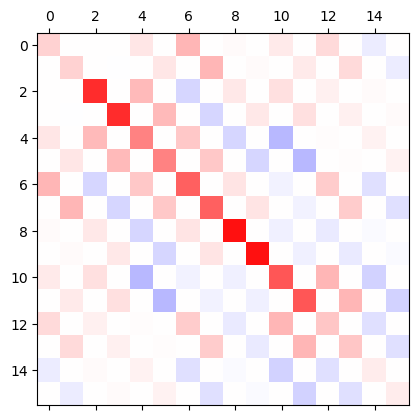

In [ ]:
# gga.gGAtomic.E

print(gga.gGAtomic.fRDM["C"][0][:4,:4])
plt.matshow(gga.gGAtomic.fRDM["C"][0].detach(), cmap="bwr", vmax=1.0, vmin=-1.0)
plt.show()

In [ ]:
from gGA.utils.tools import trans_basis_nspin

trans_basis_nspin(4,4,1,True)

tensor([[[0.7071+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j],
         [0.0000+0.0000j, 0.7071+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j],
         [0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j],
         [0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j]],

        [[0.0000+0.0000j, 0.0000+0.0000j, 0.7071+0.0000j, 0.0000+0.0000j],
         [0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.7071+0.0000j],
         [0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j],
         [0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j]],

        [[0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j],
         [0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j],
         [0.7071+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j],
         [0.0000+0.0000j, 0.7071+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j]],

        [[0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j],
         [0.0000+0.